In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.33 # Capital share of output
beta = 0.99 # Discount factor
rho = 0.8 # Persistence of technology shock
sigma = 0.1 # Standard deviation of technology shock
phi = 0.5 # Calvo parameter
theta = 2.5 # Elasticity of substitution
pi_star = 1 # Target inflation rate
y_star = 1 # Natural output level
delta = 0.55 # Depreciation rate
s = 0.1 # Share of firms that can adjust prices

In [159]:
# Steady-state values
k_star = ((1/beta - 1 + alpha) / alpha)**(1 / (alpha - 1)) #steady-state level of the capital stock
c_star = (1 - alpha) * y_star / (1/beta - (1 - delta)) #steady-state level of consumption
i_star = beta * (1 - alpha) * (y_star / k_star - 1 + delta) #steady-state level of investment

print("Steady-State Values:")
print("k_star:", k_star)
print("c_star:", c_star)
print("i_star:", i_star)

Steady-State Values:
k_star: 0.9559974710460173
c_star: 1.1962128043282232
i_star: 0.3953452873063477


In [160]:
# Grid for capital stock
k_min = 0.9 * k_star
k_max = 1.1 * k_star
num_points = 1000
num_firms = 100
k_grid = np.linspace(k_min, k_max, num_points)

In [161]:
def calvo_price_update(p, pi, s, sigma):
    num_firms = p.shape[1]
    
    # Compute aggregate price level
    try:
        p_tilde = ((1-s)*np.exp(pi) + s*np.mean(p))**(1/(1-s))
    except OverflowError:
        p_tilde = 1e10
    
    # Update prices for firms that can adjust
    for j in range(num_firms):
        if np.random.uniform() < s:
            p[:, j] = p_tilde * np.exp(np.random.normal(0, sigma, size=(p.shape[0],)))
    
    return p

In [162]:
# Create matrices for state variables and shocks
z = np.zeros(num_points) # Technology shock
e = np.random.normal(0, sigma, num_points) # Innovation to technology shock
k = np.zeros(num_points) # Capital stock
c = np.zeros(num_points) # Consumption
i = np.zeros(num_points) # Investment
pi = np.zeros(num_points) # Inflation
y = np.zeros(num_points) # Output
p = np.zeros((num_points, num_firms)) # Price

In [163]:
# Initialize variables
k[0] = k_star
c[0] = c_star
i[0] = i_star
pi[0] = 0
y[0] = y_star

In [164]:
# Iterate over time periods
for t in range(1, num_points):
    # Update technology shock
    z[t] = rho * z[t-1] + e[t]
    
    # Compute output and inflation
    y[t] = k[t-1]**alpha * np.exp((1-alpha)*z[t]) * (k[t-1]**alpha > 0) # Output
    pi[t] = phi*pi[t-1] + (1-phi)*pi_star + theta*(c[t-1]/y[t-1]-c_star/y_star) + z[t] # Inflation
    
    # Compute consumption and investment
    c[t] = (1 - alpha) * y[t] + alpha * k[t-1] - i[t-1] # Consumption
    i[t] = beta * i[t-1] + (1 - beta) * (c[t] - c[t-1]) # Investment    
        
    # Update prices
    p = calvo_price_update(p, pi[t-1], s, sigma)
    
    # Compute aggregate price level
    p_tilde = ((1-s)*np.exp(pi[t-1]) + s*np.mean(p[t-1,:]))**(1/(1-s))
    
    # Update prices for firms that can adjust
    for j in range(num_firms):
        if np.random.uniform() < s:
            p[t,j] = p_tilde * np.exp(np.random.normal(0, sigma))
    
    # Update capital stock
    k[t] = i[t] + (1 - delta) * k[t-1]

C:\Users\Admin\AppData\Local\Temp\ipykernel_29836\3134810288.py:7: RuntimeWarning: invalid value encountered in double_scalars
  y[t] = k[t-1]**alpha * np.exp((1-alpha)*z[t]) * (k[t-1]**alpha > 0) # Output


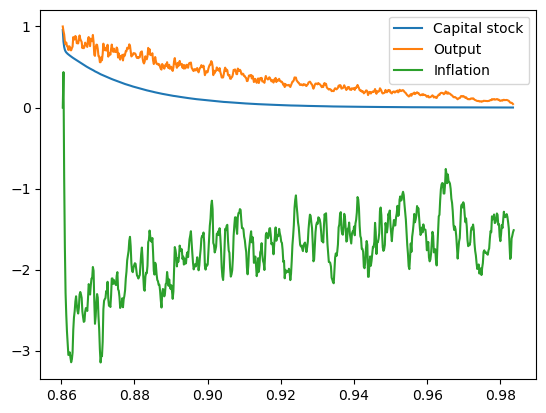

In [165]:
# Plot results
plt.plot(k_grid, k, label='Capital stock')
plt.plot(k_grid, y, label='Output')
plt.plot(k_grid, pi, label='Inflation')
plt.legend()
plt.show()